In [1]:
import json
import os
import numpy as np
import csv
import geopy
from geopy.distance import great_circle
import matplotlib.pylab as plt
import pandas as pd

%matplotlib inline

In [2]:
def match_iata_code(code,reader):
    for row in reader:
        if(row['iata_code'] == code):
            if row['id']!='326459':   #CDG weirdness
                return row['latitude_deg'],row['longitude_deg'],row['name']

In [3]:
def monthToNum(month):
    monthNum = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sep' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12
            }
    return monthNum[month]

In [4]:
def load_faredetective(flag='all'):
    ### flag = 'all': load all data, even if there are multiple prices per month
    ### flag = 'min': only load the lowest price each month
    ### flag = 'interp': load all data, but give each datum a different time code in the month
    origin = np.zeros(0,dtype='a32')
    destination = np.zeros(0,dtype='a32')
    year = np.zeros(0)
    month = np.zeros(0)
    fare = np.zeros(0)
    for root, dirs, files in os.walk("./faredetective"):  
        for filename in files:
            org = filename[:3]
            dst = filename[4:7]
            with open('./faredetective/'+filename) as json_file:
                data = json.load(json_file)
                for i in range(len(data)):
                    if flag == 'all' or flag == 'interp':
                        origin = np.append(origin,org)
                        destination = np.append(destination,dst)
                        [mn,yr] = data[i]['year'].split('\n') 
                        year = np.append(year,yr)
                        month = np.append(month,mn)
                        fare = np.append(fare,data[i]['price'])
                    elif flag == 'min':
                        [mn,yr] = data[i]['year'].split('\n') 
                        if len(month) > 0:
                            if (mn == month[-1]) and (yr == year[-1]):
                                if data[i]['price'] < fare[-1]:
                                    fare[-1] = data[i]['price']
                                else:
                                    pass
                            else:
                                origin = np.append(origin,org)
                                destination = np.append(destination,dst)
                                [mn,yr] = data[i]['year'].split('\n') 
                                year = np.append(year,yr)
                                month = np.append(month,mn)
                                fare = np.append(fare,data[i]['price'])
                        else:
                            origin = np.append(origin,org)
                            destination = np.append(destination,dst)
                            [mn,yr] = data[i]['year'].split('\n') 
                            year = np.append(year,yr)
                            month = np.append(month,mn)
                            fare = np.append(fare,data[i]['price'])
                    else:
                        print('flag is broken')
                        stop
    unique_codes = np.unique(np.concatenate([origin,destination]))
    code_name_dict = {}
    code_lat_dict = {}
    code_lon_dict = {}
    for code in unique_codes: 
        with open('airports.csv') as csvfile:
            reader = csv.DictReader(csvfile)
            lat,lon,name = match_iata_code(code,reader)
            code_name_dict[code] = name
            code_lat_dict[code] = np.float(lat)
            code_lon_dict[code] = np.float(lon)
    gc_list = []
    N = len(origin)
    for i in range(N):
        c1 = (code_lat_dict[origin[i]],code_lon_dict[origin[i]])
        c2 = (code_lat_dict[destination[i]],code_lon_dict[destination[i]])
        gcd = great_circle(c1,c2).miles
        gc_list.append(gcd)
    gc_distance = np.array(gc_list)
    month_num = ([monthToNum(month[i]) for i in range(N)])
    date_code = ([np.float(year[i]) + np.float(month_num[i])/12.0 for i in range(N)])
    df = pd.DataFrame({'Origin lat' : [code_lat_dict[origin[i]] for i in range(N)],        #0
                   'Origin lon' : [code_lon_dict[origin[i]] for i in range(N)],
                   'Destination lat' : [code_lat_dict[destination[i]] for i in range(N)],
                   'Destination lon' : [code_lon_dict[destination[i]] for i in range(N)],
                   'distance' : [gc_list[i] for i in range(N)],
                   'year' : [year[i] for i in range(N)],
                   'month' : [month_num[i] for i in range(N)],
                   'date' : [date_code[i] for i in range(N)],
                   'airfare' : [fare[i].astype(float) for i in range(N)]})
    if flag == 'interp':
        dupes = df.duplicated(subset=['Origin lat','Origin lon','Destination lat','Destination lon','date'], keep=False)
        dupe_count = np.zeros(len(dupes))
        for i in range(len(dupes)):
            if dupes[i]:
                j = i; dc = 0
                while dupes[j]:
                    j += 1
                    dc += 1
                dupe_count[i] = dc
        date_corr = 1 / (dupe_count+0.8)
        date_corr[np.where(date_corr> 1)] = 0
        df['date'] = df['date'] + date_corr/12.0
    return df.sort_values(by='date')
            

In [5]:
def load_skypicker():
    origin = np.zeros(0,dtype='a32')
    destination = np.zeros(0,dtype='a32')
    year = np.zeros(0)
    month = np.zeros(0)
    day = np.zeros(0)
    fare = np.zeros(0)
    for root, dirs, files in os.walk("./skypicker"):  
        for filename in files:
            org = filename[:3]
            dst = filename[4:7]
            fre, yr, mn, dy = np.loadtxt('./skypicker/'+filename,unpack=True)
            for i in range(len(fre)):
                origin = np.append(origin,org)
                destination = np.append(destination,dst)
                year = np.append(year,yr[i])
                month = np.append(month,mn[i])
                day = np.append(day,dy[i])
                fare = np.append(fare,fre[i])
    unique_codes = np.unique(np.concatenate([origin,destination]))
    code_name_dict = {}
    code_lat_dict = {}
    code_lon_dict = {}
    for code in unique_codes: 
        with open('airports.csv') as csvfile:
            reader = csv.DictReader(csvfile)
            lat,lon,name = match_iata_code(code,reader)
            code_name_dict[code] = name
            code_lat_dict[code] = np.float(lat)
            code_lon_dict[code] = np.float(lon)
    gc_list = []
    N = len(origin)
    for i in range(N):
        c1 = (code_lat_dict[origin[i]],code_lon_dict[origin[i]])
        c2 = (code_lat_dict[destination[i]],code_lon_dict[destination[i]])
        gcd = great_circle(c1,c2).miles
        gc_list.append(gcd)
    gc_distance = np.array(gc_list)
    date_code = ([np.float(year[i]) + np.float(month[i])/12.0 + np.float(day[i])/365.0 for i in range(N)])
    df = pd.DataFrame({'Origin lat' : [code_lat_dict[origin[i]] for i in range(N)],        #0
                   'Origin lon' : [code_lon_dict[origin[i]] for i in range(N)],
                   'Destination lat' : [code_lat_dict[destination[i]] for i in range(N)],
                   'Destination lon' : [code_lon_dict[destination[i]] for i in range(N)],
                   'distance' : [gc_list[i] for i in range(N)],
                   'year' : [year[i] for i in range(N)],
                   'month' : [month[i] for i in range(N)],
                   'date' : [date_code[i] for i in range(N)],
                   'airfare' : [fare[i].astype(float) for i in range(N)]})
    return df.sort_values(by='date')
            

In [6]:
sp = load_skypicker()
fd_interp = load_faredetective(flag='interp')
fd_min = load_faredetective(flag='min')
fd_all = load_faredetective(flag='all')

In [7]:
df_all = pd.concat([fd_all,sp])
df_min = pd.concat([fd_min,sp])
df_interp = pd.concat([fd_interp,sp])




In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler  


In [9]:
def prepare_df(df_sorted):
    ### requires df to be a sorted timeseries
    enc = OneHotEncoder(categorical_features=[0,1,2,3])
    X = df_sorted.drop(["airfare"], axis=1)
    Y = df_sorted["airfare"]
    X['Origin lon'] = X['Origin lon']+180.0
    X['Destination lon'] = X['Destination lon']+180.0
    X['Origin lat'] = X['Origin lat']+90.0
    X['Destination lat'] = X['Destination lat']+90.0
    enc.fit_transform(X)
    onehot_X = pd.concat([X['Origin lon'],X['Origin lat'],
                          X['Destination lon'],X['Destination lat']],axis=1)
    nothot_X = pd.concat([X['month'],X['distance'],X['year'],X['date']],axis=1)
    X_onehot = enc.fit_transform(onehot_X)
    X_onehot_pd = pd.DataFrame(X_onehot.todense())

    scaler = StandardScaler()  
    scaler.fit(nothot_X)  
    X_nothot = scaler.transform(nothot_X)
    X_nothot_pd = pd.DataFrame(X_nothot)

    X_new = pd.concat([X_onehot_pd,X_nothot_pd],axis=1)
    return X_new,Y,enc,scaler





In [10]:
def prepare_df_kmeans(df_sorted):
    from sklearn.cluster import KMeans
    ### requires df to be a sorted timeseries
    X = df_sorted.drop(["airfare"], axis=1)
    Y = df_sorted["airfare"]
    X['Origin lon'] = X['Origin lon']+180.0
    X['Destination lon'] = X['Destination lon']+180.0
    X['Origin lat'] = X['Origin lat']+90.0
    X['Destination lat'] = X['Destination lat']+90.0
    kmeans_origin = KMeans(n_clusters=20, random_state=0).fit(X[['Origin lon','Origin lat']])
    kmeans_destination = kmeans_origin.predict(X[['Destination lon','Destination lat']])
    d = {'orgs': kmeans_origin.labels_, 'dests': kmeans_destination}
    dt = pd.DataFrame(data=d)
    enc = OneHotEncoder()
    X_onehot = enc.fit_transform(dt)
    X_onehot_pd = pd.DataFrame(X_onehot.todense())

    nothot_X = pd.concat([X['month'],X['distance'],X['year'],X['date']],axis=1)
    scaler = StandardScaler()  
    scaler.fit(nothot_X)  
    X_nothot = scaler.transform(nothot_X)
    X_nothot_pd = pd.DataFrame(X_nothot)

    X_new = pd.concat([X_onehot_pd,X_nothot_pd],axis=1)
    return X_new,Y,enc,scaler,kmeans_origin

In [11]:
def test_timeseries(X,Y,n_splits=5,name='neural'):
    count = 0
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]
        reg = MLPRegressor(hidden_layer_sizes=(20,20,20),max_iter=10000)
        reg.fit(X_train, Y_train)
        Y_pred = reg.predict(X_test)
        plt.figure()
        plt.clf()
        plt.hist(Y_pred/Y_test,bins=20)
        plt.xlabel('predicted / true airfare')
        plt.ylabel('N')
        ratio = Y_pred/Y_test
        plt.title("mean: %0.2f (+/- %0.2f)" % (ratio.mean(), ratio.std()))
        plt.savefig(name+'_'+str(count)+'.pdf')
        count += 1



In [12]:
def fit_timeseries(X,Y):
    reg = MLPRegressor(hidden_layer_sizes=(20,20,20),max_iter=10000)
    reg.fit(X, Y)
    return reg

In [13]:
def predict_airfares(route,encoder,scaler,reg,N_months=18):
    #### route = 'MUC-YVR', for example
    origin = route[:3]
    destination = route[-3:]
    print(origin)
    print(destination)
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        origin_lat,origin_lon,_ = match_iata_code(origin,reader)
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        destination_lat,destination_lon,_ = match_iata_code(destination,reader)
    print(origin_lat)
    c1 = (origin_lat,origin_lon)
    c2 = (destination_lat,destination_lon)
    gcd = great_circle(c1,c2).miles
    from datetime import datetime, timedelta, date, time
    a = pd.date_range(start=datetime.today(), periods=N_months,freq='m')
    month_num = a.month
    year= a.year
    date_code = a.year + a.month/12.0 + 1.0/24.0
    X_extrapolate = pd.DataFrame({'Origin lat' : [np.float(origin_lat) for i in range(N_months)],        #0
                       'Origin lon' : [np.float(origin_lon) for i in range(N_months)],
                       'Destination lat' : [np.float(destination_lat) for i in range(N_months)],
                       'Destination lon' : [np.float(destination_lon) for i in range(N_months)],
                       'distance' : [gcd for i in range(N_months)],
                       'year' : [year[i] for i in range(N_months)],
                       'month' : [month_num[i] for i in range(N_months)],
                        'date' : [date_code[i] for i in range(N_months)]})
    X_extrapolate['Origin lon'] = X_extrapolate['Origin lon']+180.0
    X_extrapolate['Destination lon'] = X_extrapolate['Destination lon']+180.0
    X_extrapolate['Origin lat'] = X_extrapolate['Origin lat']+90.0
    X_extrapolate['Destination lat'] = X_extrapolate['Destination lat']+90.0

    onehot_X = pd.concat([X_extrapolate['Origin lon'],X_extrapolate['Origin lat'],
                          X_extrapolate['Destination lon'],X_extrapolate['Destination lat']],axis=1)

    nothot_X = pd.concat([X_extrapolate['month'],X_extrapolate['distance'],X_extrapolate['year'],X_extrapolate['date']],axis=1)

    X_onehot = encoder.transform(onehot_X)
    X_onehot_pd = pd.DataFrame(X_onehot.todense())

    X_nothot = scaler.transform(nothot_X)
    X_nothot_pd = pd.DataFrame(X_nothot)

    X_new = pd.concat([X_onehot_pd,X_nothot_pd],axis=1)
    Y_new = reg.predict(X_new)
    return date_code,Y_new

In [14]:
def predict_airfares_kmeans(route,encoder,scaler,reg,kmeans,N_months=18):
    #### route = 'MUC-YVR', for example
    origin = route[:3]
    destination = route[-3:]
    print(origin)
    print(destination)
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        origin_lat,origin_lon,_ = match_iata_code(origin,reader)
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        destination_lat,destination_lon,_ = match_iata_code(destination,reader)
    print(origin_lat)
    c1 = (origin_lat,origin_lon)
    c2 = (destination_lat,destination_lon)
    gcd = great_circle(c1,c2).miles
    from datetime import datetime, timedelta, date, time
    a = pd.date_range(start=datetime.today(), periods=N_months,freq='m')
    month_num = a.month
    year= a.year
    date_code = a.year + a.month/12.0 + 1.0/24.0
    X_extrapolate = pd.DataFrame({'Origin lat' : [np.float(origin_lat) for i in range(N_months)],        #0
                       'Origin lon' : [np.float(origin_lon) for i in range(N_months)],
                       'Destination lat' : [np.float(destination_lat) for i in range(N_months)],
                       'Destination lon' : [np.float(destination_lon) for i in range(N_months)],
                       'distance' : [gcd for i in range(N_months)],
                       'year' : [year[i] for i in range(N_months)],
                       'month' : [month_num[i] for i in range(N_months)],
                        'date' : [date_code[i] for i in range(N_months)]})
    X_extrapolate['Origin lon'] = X_extrapolate['Origin lon']+180.0
    X_extrapolate['Destination lon'] = X_extrapolate['Destination lon']+180.0
    X_extrapolate['Origin lat'] = X_extrapolate['Origin lat']+90.0
    X_extrapolate['Destination lat'] = X_extrapolate['Destination lat']+90.0
    kmeans_origin = kmeans.predict(X_extrapolate[['Origin lon','Origin lat']])    
    kmeans_destination = kmeans.predict(X_extrapolate[['Destination lon','Destination lat']])
    d = {'orgs': kmeans_origin, 'dests': kmeans_destination}
    dt = pd.DataFrame(data=d)
    #print(dt)
    X_onehot = encoder.transform(dt)
    X_onehot_pd = pd.DataFrame(X_onehot.todense())

    nothot_X = pd.concat([X_extrapolate['month'],X_extrapolate['distance'],X_extrapolate['year'],X_extrapolate['date']],axis=1)
    X_nothot = scaler.transform(nothot_X)
    X_nothot_pd = pd.DataFrame(X_nothot)

    X_new = pd.concat([X_onehot_pd,X_nothot_pd],axis=1)
    #print(X_new)
    Y_new = reg.predict(X_new)
    return date_code,Y_new

In [15]:
def test_test_fit(df,prefix,route):
    X = df.drop(["airfare"], axis=1)
    Y = df["airfare"]
    test_timeseries(X,Y,n_splits=5,name=prefix+'_noscaling')
    X,Y,encoder,scaler,kmeans = prepare_df_kmeans(df)
    test_timeseries(X,Y,n_splits=5,name=prefix+'_scaled')
    reg = fit_timeseries(X,Y)
    dates,preds = predict_airfares_kmeans(route,encoder,scaler,reg,kmeans,N_months=18)
    origin = route[:3]
    destination = route[-3:]
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        origin_lat,origin_lon,_ = match_iata_code(origin,reader)
    with open('airports.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        destination_lat,destination_lon,_ = match_iata_code(destination,reader)
    matches = df.loc[(df['Origin lon'] == np.float(origin_lon)) *
                         (df['Destination lat'] == np.float(destination_lat))]
    #print(matches)
    plt.figure()
    plt.clf()
    plt.plot(matches['date'],matches['airfare'],'ok')
    plt.plot(dates,preds,'-r',lw=2,alpha=0.7)
    plt.savefig('/Users/michevan/Desktop/insight/'+prefix+'_'+route+'_pred.pdf')
    plt.xlim([2018.4,2020])
    plt.savefig('/Users/michevan/Desktop/insight/'+prefix+'_'+route+'_pred_zoom.pdf')
    return dates,preds

MUC
LAS
48.353802


/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


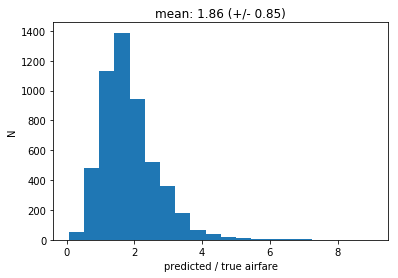

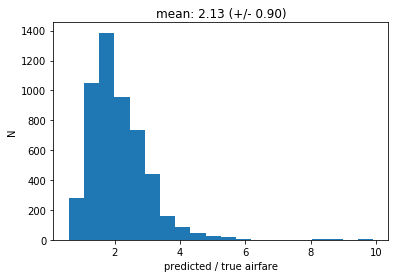

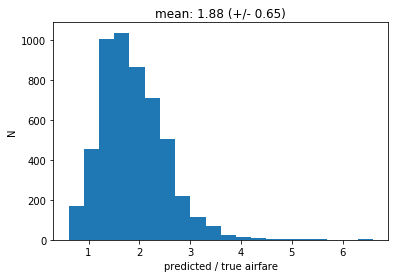

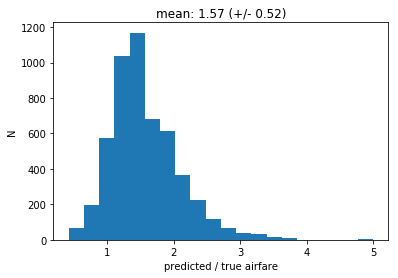

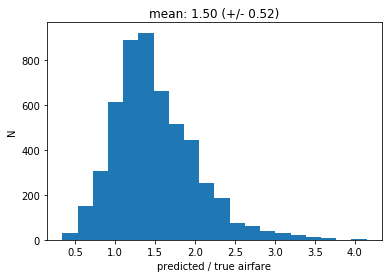

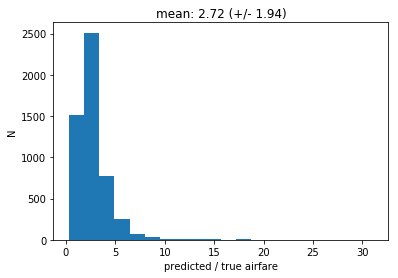

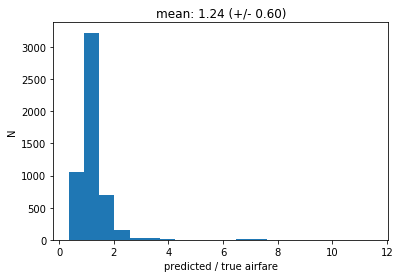

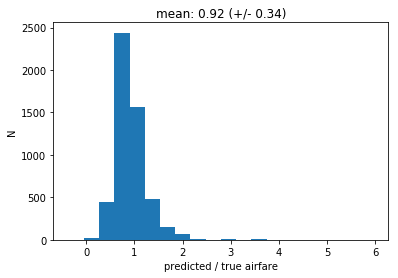

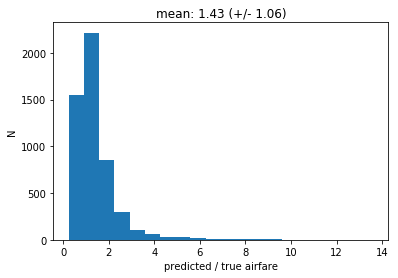

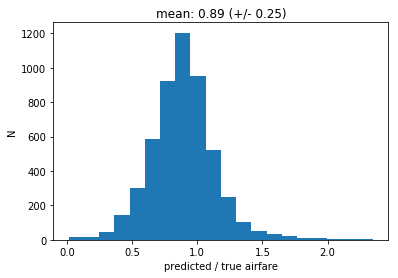

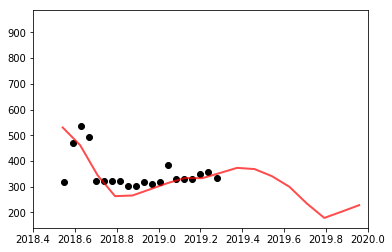

In [16]:
dates,preds = test_test_fit(df_all,'k_all','MUC-LAS')

MUC
LAS
48.353802


/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


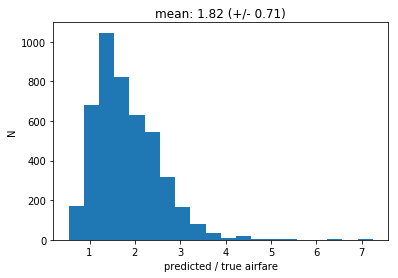

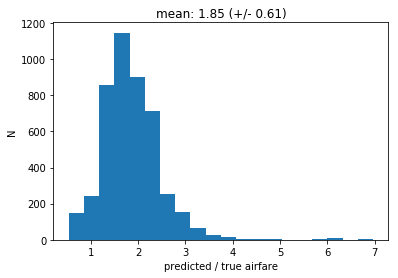

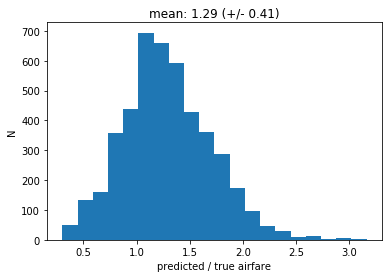

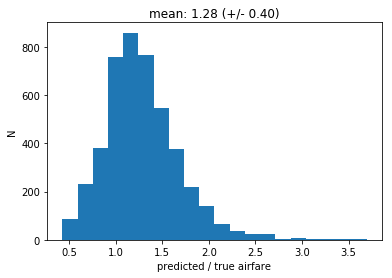

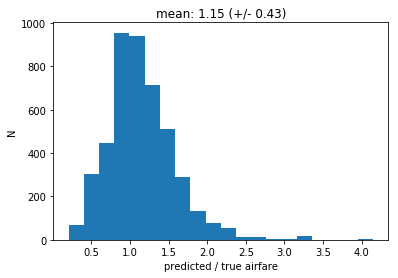

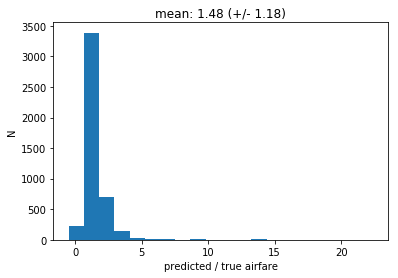

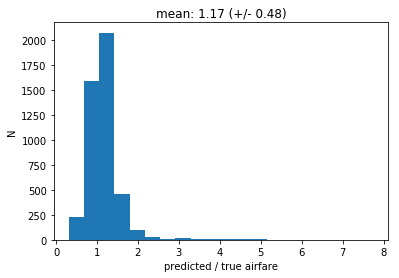

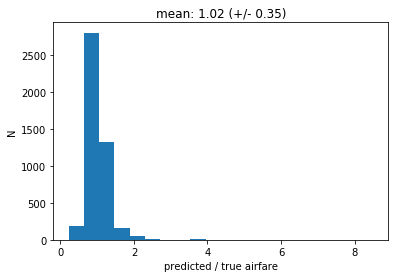

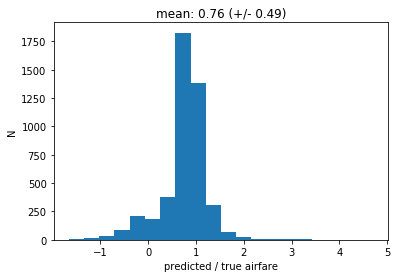

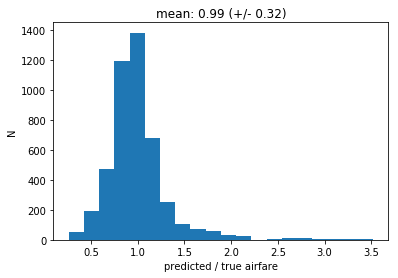

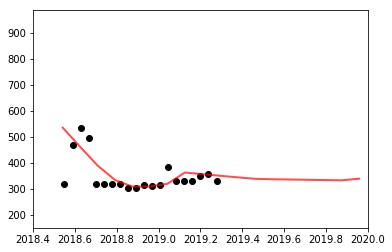

In [17]:
dates,preds = test_test_fit(df_min,'k_min','MUC-LAS')

MUC
LAS
48.353802


/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


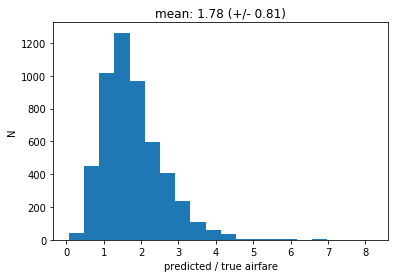

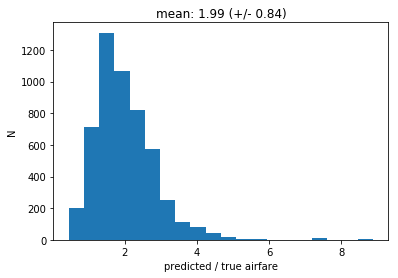

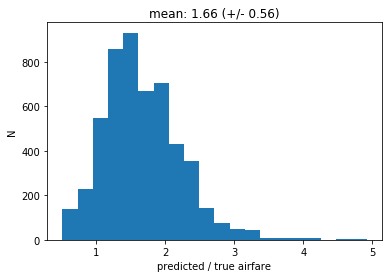

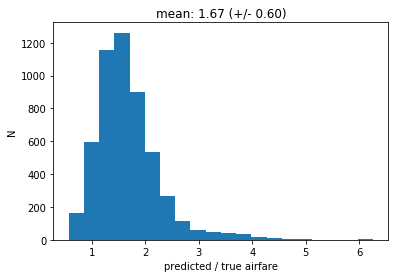

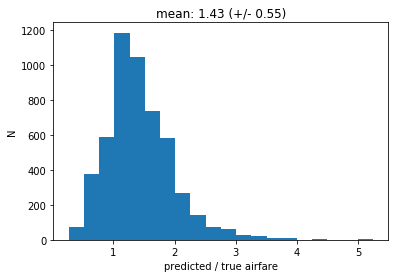

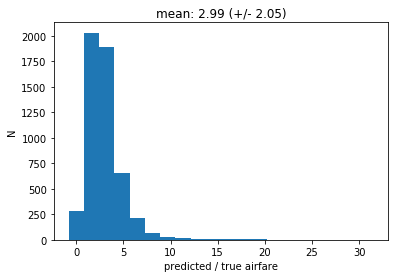

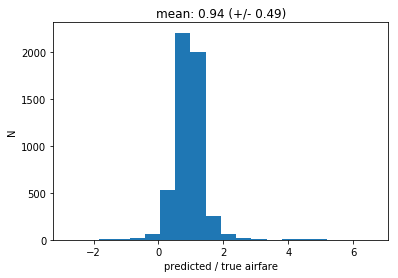

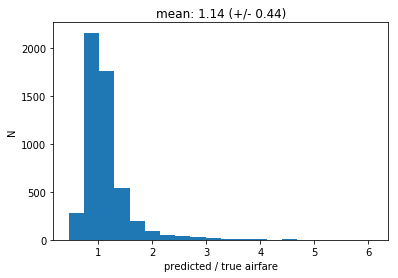

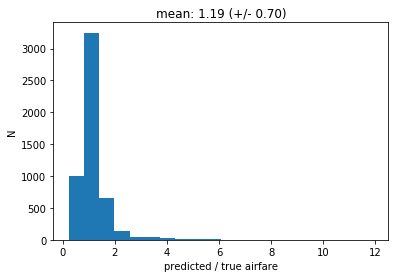

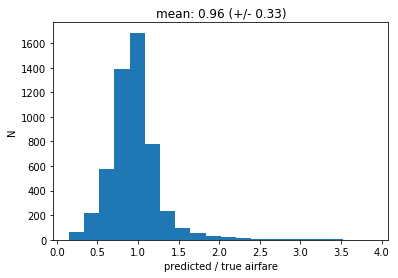

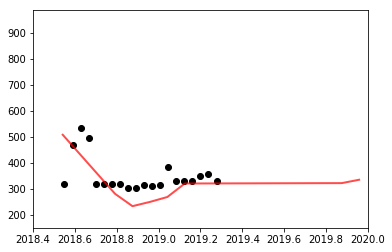

In [18]:
dates,preds = test_test_fit(df_interp,'k_interp','MUC-LAS')

NameError: name 'stop' is not defined